# SDC: before 1st Project

## How to setup kernel env:
I had some difficulties to setup the jupyter notebook to manage the kernels and using the proper  python enviornment in Anaconda3-4.3.0. In previous versions it was quite easier (at least for beginners like me). This is how I set it up and currently working :) 

Sources:
0. https://ipython.readthedocs.io/en/latest/install/kernel_install.html
0http://jupyter.readthedocs.io/en/latest/install-kernel.html
0. https://conda.io/docs/using/envs.html#create-an-environment

If you are using the python3
```
python -m pip install ipykernel
conda create --name carnd_linelane
source activate carnd_linelane
conda install -c https://conda.anaconda.org/menpo opencv3
pip install moviepy pillow
conda install matplotlib numpy
python -m ipykernel install --user --name carnd_linelane --display-name "Python (carnd_linelane)"
jupyter notebook
```

and now you can choose   `Python (carnd_linelane)` in the kernel list of jupyter nptebook with required libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

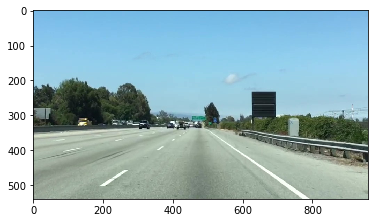

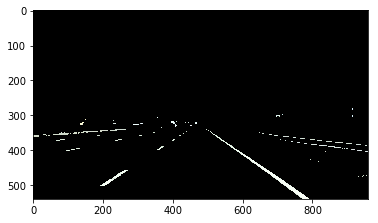

In [9]:
# color selection

# Read in the image
image = mpimg.imread('test.jpg')
plt.imshow(image)
plt.show()

# Grab the x and y size and make a copy of the image
ysize = image.shape[0]
xsize = image.shape[1]
color_select = np.copy(image)

# Define color selection criteria
###### MODIFY THESE VARIABLES TO MAKE YOUR COLOR SELECTION
red_threshold = 200
green_threshold = 200
blue_threshold = 200
######

rgb_threshold = [red_threshold, green_threshold, blue_threshold]

# Do a boolean or with the "|" character to identify
# pixels below the thresholds
thresholds = (image[:,:,0] < rgb_threshold[0]) \
            | (image[:,:,1] < rgb_threshold[1]) \
            | (image[:,:,2] < rgb_threshold[2])
color_select[thresholds] = [0,0,0]
# Display the image 
plt.figure()
plt.imshow(color_select)
plt.show()

# Uncomment the following code if you are running the code locally and wish to save the image
mpimg.imsave("test-after.jpg", color_select)

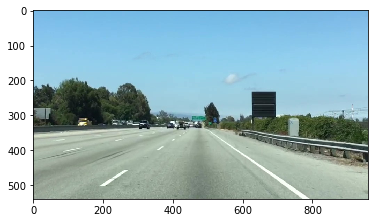

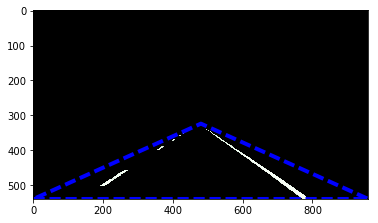

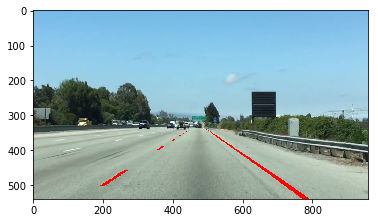

In [10]:
# region selection

# Read in the image and print out some stats
# Note: in the previous example we were reading a .jpg 
# Here we read a .png and convert to 0,255 bytescale
image = mpimg.imread('test.jpg')

# Grab the x and y size and make a copy of the image
ysize = image.shape[0]
xsize = image.shape[1]
color_select = np.copy(image)
line_image = np.copy(image)

# Define color selection criteria
# MODIFY THESE VARIABLES TO MAKE YOUR COLOR SELECTION
red_threshold = 200
green_threshold = 200
blue_threshold = 200

rgb_threshold = [red_threshold, green_threshold, blue_threshold]

# Define the vertices of a triangular mask.
# Keep in mind the origin (x=0, y=0) is in the upper left
# MODIFY THESE VALUES TO ISOLATE THE REGION 
# WHERE THE LANE LINES ARE IN THE IMAGE
left_bottom = [0, ysize]
right_bottom = [xsize, ysize]
apex = [xsize/2, 6*ysize/10]

# left_bottom = [0, 539], right_bottom [900, 539], and apex = [475, 320]

# Perform a linear fit (y=Ax+B) to each of the three sides of the triangle
# np.polyfit returns the coefficients [A, B] of the fit
fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

# Mask pixels below the threshold
color_thresholds = (image[:,:,0] < rgb_threshold[0]) | \
                    (image[:,:,1] < rgb_threshold[1]) | \
                    (image[:,:,2] < rgb_threshold[2])

# Find the region inside the lines
XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                    (YY > (XX*fit_right[0] + fit_right[1])) & \
                    (YY < (XX*fit_bottom[0] + fit_bottom[1]))
                    
# Mask color and region selection
color_select[color_thresholds | ~region_thresholds] = [0, 0, 0]
# Color pixels red where both color and region selections met
line_image[~color_thresholds & region_thresholds] = [255, 0, 0]

# Display the image and show region and color selections
plt.imshow(image)
plt.figure()
x = [left_bottom[0], right_bottom[0], apex[0], left_bottom[0]]
y = [left_bottom[1], right_bottom[1], apex[1], left_bottom[1]]
plt.plot(x, y, 'b--', lw=4)
plt.imshow(color_select)
plt.figure()
plt.imshow(line_image)
plt.show()

## Detecting Line as a Real Line and not only color and region filtering

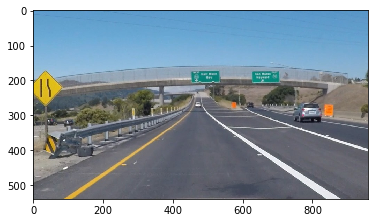

(540, 960, 3)

In [11]:
image = mpimg.imread('exit-ramp.jpg')
plt.imshow(image)
plt.show()
image.shape

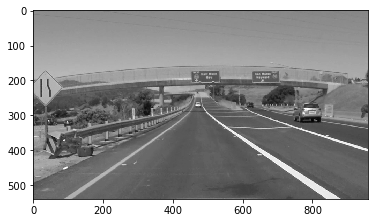

(540, 960)

In [12]:
# convert to gray scale
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) #grayscale conversion
plt.imshow(gray, cmap='gray')
plt.show()
gray.shape

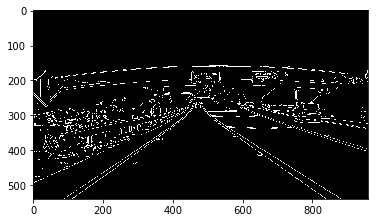

In [13]:
# Edge detection without gaussian filter
low_threshold = 100
high_threshold = 200
edges = cv2.Canny(gray, low_threshold, high_threshold)
plt.imshow(edges, cmap='gray')
plt.show()

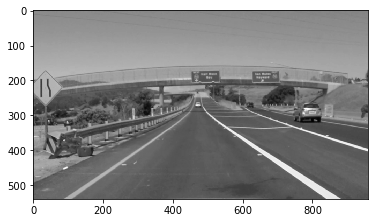

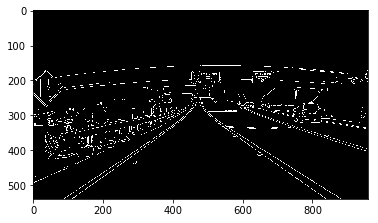

In [14]:
#  Edge detection with gaussian filter
kernel_size = 3
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size), 0)
plt.imshow(blur_gray, cmap='gray')
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
plt.figure()
plt.imshow(edges, cmap='Greys_r')
plt.show()

# Hough Space and Trasformation

[Hough Transformation Description](https://alyssaq.github.io/2014/understanding-hough-transform/):

Algorithm steps:
0. Corner or edge detection. (E.g. using canny, sobel, adaptive thresholding). The resultant binary/grey image will have 0s indicating non-edges and 1s or above indicating edges. This is our input image.
0. Rho range and Theta range creation. ρ ranges from -max_dist to max_dist where max_dist is the diagonal length of the input image. θ ranges from −90∘ to 90∘. You can have more or less bins in the ranges to tradeoff accuracy, space and speed. E.g. Every third angle in −90∘ to 90∘ to reduce from 180 to 60 values.
0. Hough accumulator of θ vs ρ. It is a 2D array with the number of rows equal to the number of ρρ values and the number of columns equal to the number of θ values.
0. Voting in the accumulator. For each edge point and for each θθ value, find the nearest ρ value and increment that index in the accumulator. Each element tells how many points/pixels contributed “votes” for potential line candidates with parameters (ρ,θ).
0. Peak finding. Local maxima in the accumulator indicates the parameters of the most prominent lines in the input image. Peaks can be found most easily by applying a threshold or a relative threshold (values equal to or greater than some fixed percentage of the global maximum value).